# 参考情報-1
# DCASE Task2のホームページ

http://dcase.community/challenge2020/task-unsupervised-detection-of-anomalous-sounds

今回のワークショップで元にしたソースコード(tensorflow+keras)やデータがあります。ご参考まで。

#参考情報-2
#Deep Learningの基礎
https://tutorials.chainer.org/ja/tutorial.html

#Pytorchのチュートリアル
https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

ネットを探せばいくらでも情報はあると思いますが、体系立ててまとまっており個人的なお勧めとしてご紹介致します。

#A. 準備
まずは、データを用意したり、必要なモジュールを宣言するなどのプログラム実行のための環境構築を行います。

# A.1 データのダウンロード

直下のコードを実行し、今回の体験講座で使うデータなどをダウンロードします。

中身は、音データ（.wav）と、サンプルデータを聴いたり可視化するために体験講座用に用意したメタデータ（.csv）です。

In [ ]:
#1 データセットをダウンロード
%%shell
wget https://workshop-aicoe.s3-ap-northeast-1.amazonaws.com/dev_data.zip
wget https://workshop-aicoe.s3-ap-northeast-1.amazonaws.com/filelist.csv
wget https://workshop-aicoe.s3-ap-northeast-1.amazonaws.com/testlist.csv
# カレント・フォルダにzipファイルを解凍
unzip dev_data.zip

#A.2 ダウンロードしたデータの確認
ブラウザー左脇のツールバーにあるフォルダーのアイコンを開いてみてください。この学習環境にあるデータなどが表示され、ダウンロードしたファイルが格納されたことが分かります。

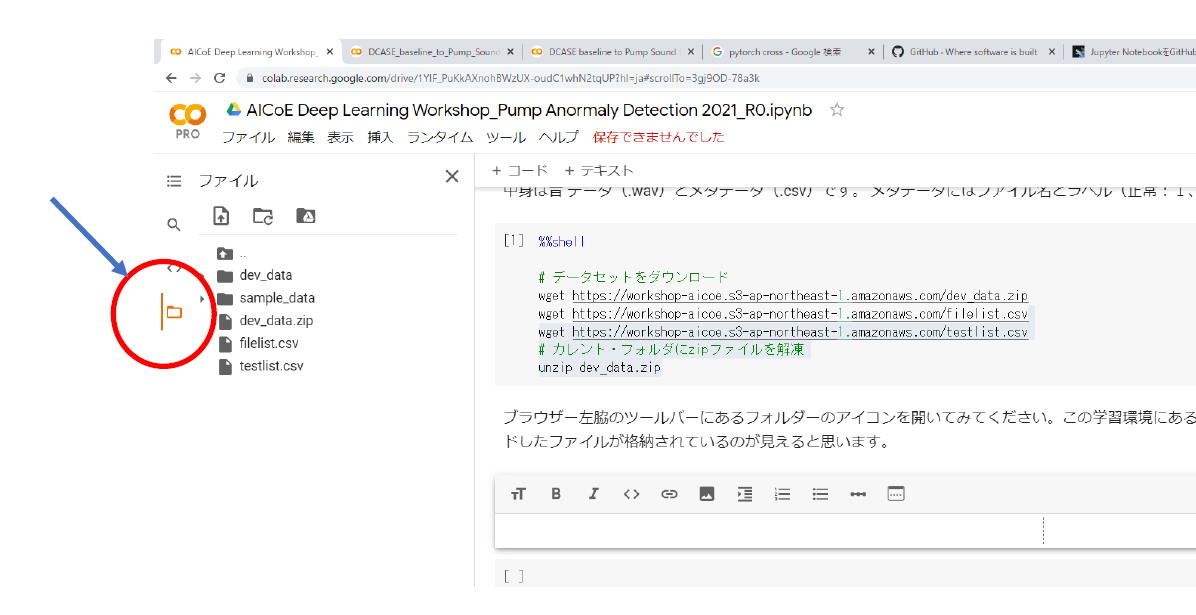

# A.3 前処理に向けた準備


In [ ]:
#2 学習の際に進捗状況を可視化できるように、必要なコードを宣言しておく
import logging

logging.basicConfig(level=logging.DEBUG, filename="baseline.log")
logger = logging.getLogger(' ')
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

In [ ]:
import torch
import numpy as np

seed = 0
# Pytorch
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

# numpy の seed を固定
np.random.seed(seed)

In [ ]:
#3 必要なモジュールを呼び出しておく
import os
import glob
import time
from collections import defaultdict
from datetime import timedelta
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [ ]:
#4 プログラム全体を通して頻繁にデータへアクセスするため、ファルダ―内のファイルパスを宣言しておく
import pandas as pd

# フォルダー内のファイルパスを、今後のコードで読み出すときに使いやすいように宣言しておく
base_dir = "./dev_data/"
esc_dir = os.path.join(base_dir, "pump/")
audio_dir = os.path.join(esc_dir, "train/")
audio_dir2 = os.path.join(esc_dir, "test/")

# サンプルを試聴したり、波形やログメルスペクトログラムの描画するためのリストも読み込む。
meta_data = pd.read_csv("filelist.csv")
meta_data2 = pd.read_csv("testlist.csv")

# 学習用のデータのサイズを確認する
data_size = meta_data.shape
print(data_size)

# テスト用のデータのサイズを確認する
data_size = meta_data2.shape
print(data_size)

(3349, 2)
(856, 2)


#A.4 サンプルデータを取り込み正常音と異常音を聞いてみる
試しに、テストデータに含まれる正常音と異常音を取り込み、どのようなものか確かめてみましょう。

In [ ]:
#5 サンプル音データをColaboratoryに読み込むためのコード 
import IPython.display as ipd

def load_wave_data(audio_dir, file_name):
    file_path = os.path.join(audio_dir2, file_name)
    x, fs = librosa.load(file_path)
    return x,fs

In [ ]:
#6 正常データを再生する
normal, fs = load_wave_data(audio_dir2, meta_data2.loc[2, "filename"])
print(meta_data2.loc[2, "filename"])
ipd.Audio(normal, rate=fs)

In [ ]:
#7 異常データを再生する
anormal, fs = load_wave_data(audio_dir2, meta_data2.loc[0, "filename"])
print(meta_data2.loc[0, "filename"])
ipd.Audio(anormal, rate=fs)


#B.前処理
ここでは、AIにデータを学習させるためのデータセットを用意します。

#B.1 サンプルデータを使った波形データおよび対数メルスペクトログラムの描画

音データをAIで扱えるようにするためには、音をデータとして捕捉し、電流や電圧などで構成されるアナログデータから0と1で構成されるデジタルデータに変換する必要があります。そのため、音はマイクロフォンなどの集音機を使って集音され、集音機内部でアナログからデジタルに変換され、今回利用するWAVデータのような標準的な情報構造に整えられた形で蓄積されます。

音データは、周波数や振幅と呼ばれる特徴量を持った波形データです。今回は、音データの特徴量を際立たせるためにフーリエ変換という方法で波形データを周波数ごとの成分（スペクトル）に変換し、さらにフィルターバンクと呼ばれるフィルターにかけ対数メルスペクトルと呼ばれる音データの特徴量に変換します。

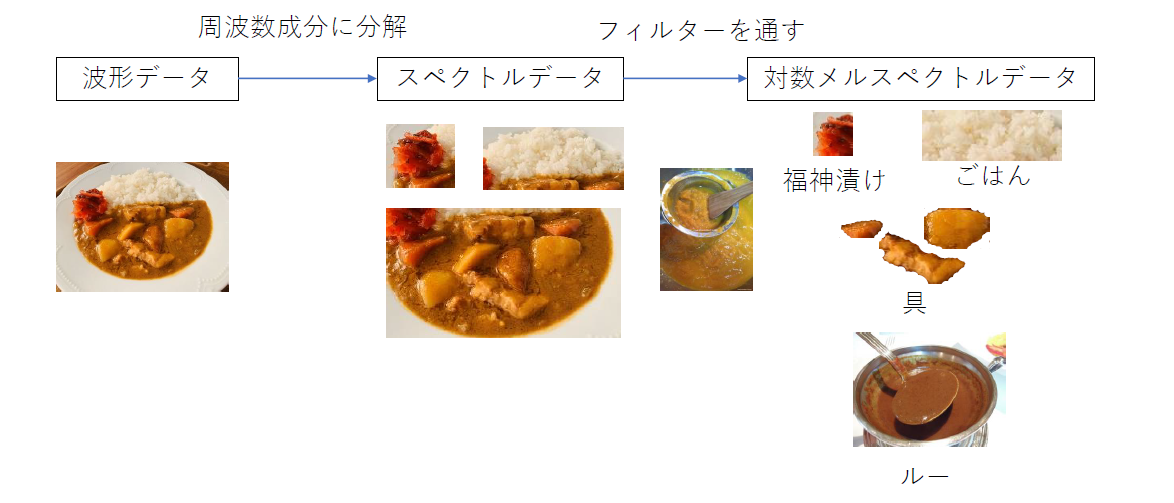


In [ ]:
#8 波形データを対数メルスペクトログラムに変換する
def calculate_melsp(x, n_fft=1024, hop_length=512):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=64)
    return melsp

In [ ]:
#9 波形および対数メルスペクトログラムを表示する
# 音データ(.wav)の波形を表示する
def show_wave(x):
    plt.plot(x)
    plt.show()

# 対数メルスペクトログラムを表示する
def show_melsp(melsp, fs):
    librosa.display.specshow(melsp, sr=fs)
    plt.colorbar()
    plt.show()

In [ ]:
#10 正常音の波形およびメルスペクトログラムを表示する
x, fs = load_wave_data(audio_dir2, meta_data2.loc[2, "filename"])
print(meta_data2.loc[2, "filename"])
print("wave size:{0}\nsamping rate:{1}".format(x.shape, fs))
show_wave(x)
melsp = calculate_melsp(x)
print("nmelsp size:{0}".format(melsp.shape))
show_melsp(melsp, fs)

NameError: ignored

In [ ]:
#11 異常音の波形およびメルスペクトログラムを表示する
x, fs = load_wave_data(audio_dir2, meta_data2.loc[0, "filename"])
print(meta_data2.loc[0, "filename"])
print("wave size:{0}\nsamping rate:{1}".format(x.shape, fs))
show_wave(x)
melsp = calculate_melsp(x)
print("nmelsp size:{0}".format(melsp.shape))
show_melsp(melsp, fs)

#B.2 学習用データを取り込み、データの前処理をおこなう。

B.1では音データ(.wav)を加工して対数メルスペクトログラムにする前処理技術の説明をしました。ここでは、今回学習に使う全ての音データを取り込みAIの入力となる学習用データセットを作成します。

In [ ]:
#12 学習用の音データ(.wav)をColaboratoryの環境に取り込む
def file_load(wav_name, mono=False):
    try:
        return librosa.load(wav_name, sr=None, mono=mono)
    except:
        logger.error("file_broken or not exists!! : {}".format(wav_name))

In [ ]:
#13 読み込んだ音データを対数メルスペクトルデータに変換する
def file_to_vector_array(file_name,
                         n_mels=64,
                         frames=5,
                         n_fft=1024,
                         hop_length=512,
                         power=2.0):
    """
    convert file_name to a vector array.

    file_name : str
        target .wav file

    return : numpy.array( numpy.array( float ) )
        vector array
        * dataset.shape = (dataset_size, feature_vector_length)
    """
    # 01 calculate the number of dimensions
    dims = n_mels * frames

    # 02_03 generate melspectrogram using librosa
    y, sr = file_load(file_name)
    stft = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    log_mel_spectrogram = librosa.feature.melspectrogram(S=log_stft,n_mels=n_mels)

    # 04 calculate total vector size
    vector_array_size = len(log_mel_spectrogram[0, :]) - frames + 1

    # 05 skip too short clips
    if vector_array_size < 1:
        return np.empty((0, dims))

    # 06 generate feature vectors by concatenating multiframes
    vector_array = np.zeros((vector_array_size, dims))
    for t in range(frames):
        vector_array[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t: t + vector_array_size].T

    return vector_array

In [ ]:
#14 データを制御しやすいように各データに番号を振り、データセットを作成する
class dcaseDataset(torch.utils.data.Dataset):
    def __init__(self, target_dir, dir_name, ext="wav",
                 n_mels=64, frames=5, n_fft=1024, hop_length=512, power=2.0,
                 transform=None):
        self.transform = transform

        logger.info("target_dir : {}".format(target_dir))

        file_list_path = os.path.abspath(
            "{dir}/{dir_name}/*.{ext}".format(dir=target_dir, dir_name=dir_name,
                                              ext=ext))
        files = sorted(glob.glob(file_list_path))
        if len(files) == 0:
            logger.exception("no_wav_file!!")

        logger.info("train_file num : {num}".format(num=len(files)))

        dims = n_mels * frames
        for idx in range(len(files)):
            vector_array = file_to_vector_array(files[idx],
                                                    n_mels=n_mels,
                                                    frames=frames,
                                                    n_fft=n_fft,
                                                    hop_length=hop_length,
                                                    power=power)
            if idx == 0:
                dataset = np.zeros(
                    (vector_array.shape[0] * len(files), dims), float)

            dataset[vector_array.shape[0] * idx:
                    vector_array.shape[0] * (idx + 1), :] = vector_array

        self.feat_data = dataset

    def __len__(self):
        return self.feat_data.shape[0]  # return num of samples

    def __getitem__(self, index):
        sample = self.feat_data[index, :]  # return vector

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
#15 データセット作成を実行し、作成したデータを学習用90%と検証用10%に分割する。
dataset = dcaseDataset(target_dir=esc_dir,
                       dir_name="train",
                               n_mels=64,
                               frames=5,
                               n_fft=1024,
                               hop_length=512,
                               power=2.0)
n_samples = len(dataset)
train_size = int(n_samples * (1.0 - 0.1))
subset1_indices = list(range(0, train_size))
subset2_indices = list(range(train_size, n_samples))
train_dataset = torch.utils.data.Subset(dataset, subset1_indices)
val_dataset = torch.utils.data.Subset(dataset, subset2_indices)

2021-05-17 12:02:08,398 - INFO - target_dir : ./dev_data/pump/
2021-05-17 12:02:08,412 - INFO - train_file num : 3349


In [ ]:
#16 データセットを制御して、データをAIに移す
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=512,
    shuffle=True,
    drop_last=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=512,
    shuffle=False,
    drop_last=False)

#C モデルの記述・設定

ここでは、今回用いる異常検知用のオードエンコーダモデルを記述し、誤差を評価するための方法や、パラメータの初期値などを設定しています。

#C.1 モデルの記述
今回のオートエンコーダ―モデルを概念図であらわすと、以下のような9層のニューラルネットワークとなります。

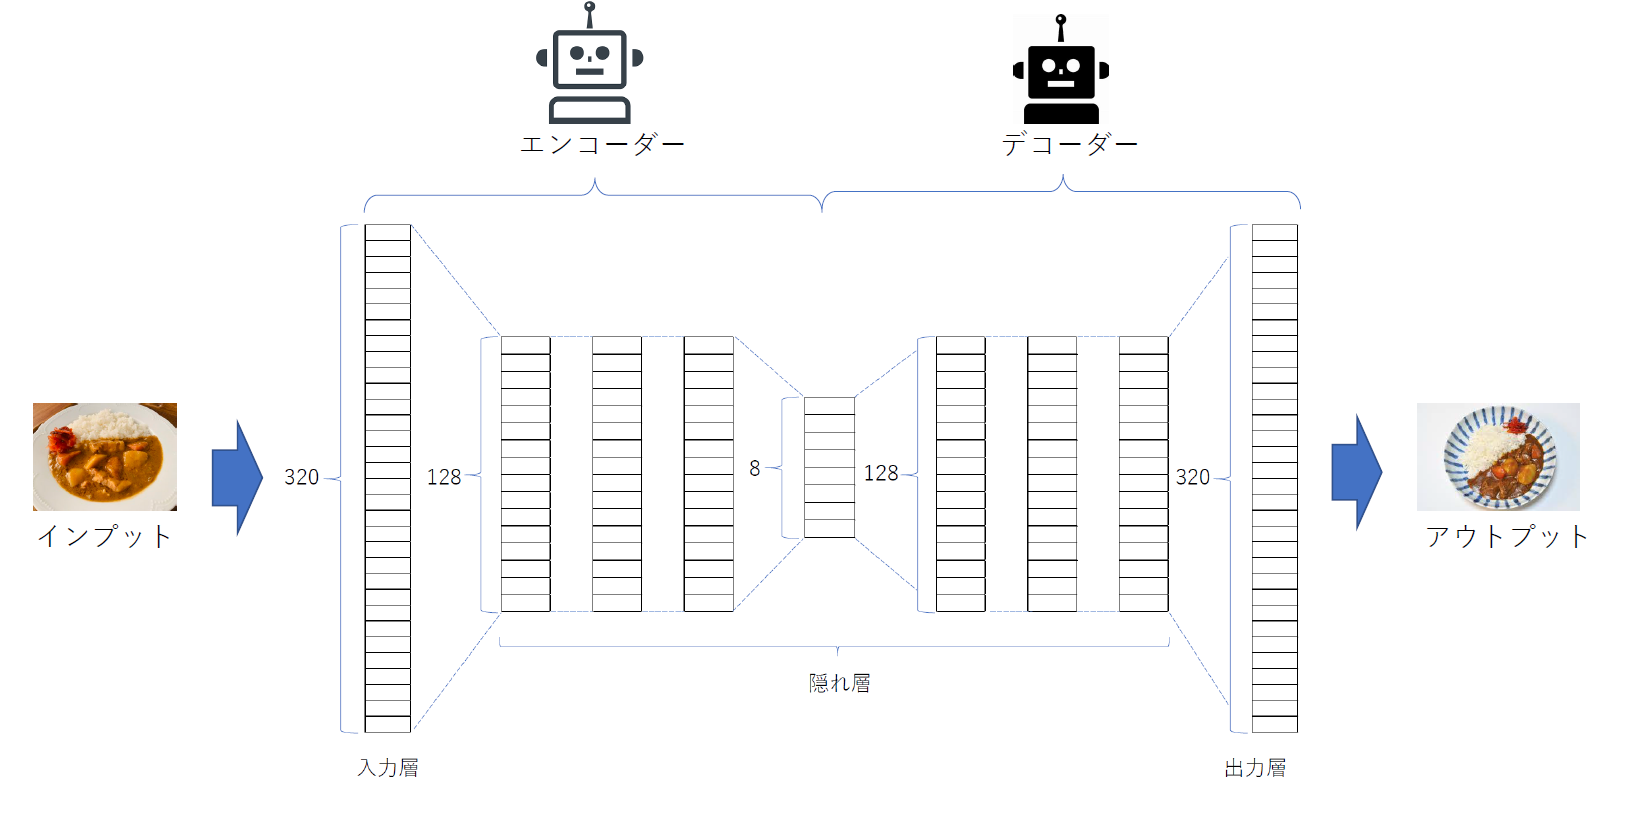

In [ ]:
#17 深層学習モデルを記述する
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        layers = [nn.Linear(320, 128),
                  nn.Linear(128, 128),
                  nn.Linear(128, 128),
                  nn.Linear(128, 128),
                  nn.Linear(128, 8),
                  nn.Linear(8, 128),
                  nn.Linear(128, 128),
                  nn.Linear(128, 128),
                  nn.Linear(128, 128),
                  nn.Linear(128, 320), ]
        self.layers = nn.ModuleList(layers)

        bnorms = [nn.BatchNorm1d(128),
                  nn.BatchNorm1d(128),
                  nn.BatchNorm1d(128),
                  nn.BatchNorm1d(128),
                  nn.BatchNorm1d(8),
                  nn.BatchNorm1d(128),
                  nn.BatchNorm1d(128),
                  nn.BatchNorm1d(128),
                  nn.BatchNorm1d(128), ]
        self.bnorms = nn.ModuleList(bnorms)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        hidden = self.relu(self.bnorms[0](self.layers[0](inputs)))  # 320->128
        hidden = self.relu(self.bnorms[1](self.layers[1](hidden)))  # 128->128
        hidden = self.relu(self.bnorms[2](self.layers[2](hidden)))  # 128->128
        hidden = self.relu(self.bnorms[3](self.layers[3](hidden)))  # 128->128
        hidden = self.relu(self.bnorms[4](self.layers[4](hidden)))  # 128->8
        hidden = self.relu(self.bnorms[5](self.layers[5](hidden)))  # 8->128
        hidden = self.relu(self.bnorms[6](self.layers[6](hidden)))  # 128->128
        hidden = self.relu(self.bnorms[7](self.layers[7](hidden)))  # 128->128
        hidden = self.relu(self.bnorms[8](self.layers[8](hidden)))  # 128->128
        output = self.layers[9](hidden)                             # 128->320

        return output

model = AutoEncoder()

# C.2　順伝搬と誤差逆伝搬
深層学習では、AIが学習用データを受け取りアウトプットするまでのプロセスを順伝搬（フォワードプロパゲーション）と呼びます。また、深層学習モデルには、インプットとアウトプットの誤差を計算し、誤差を縮めるためにパラメータを更新するフィードバック機構が設けられています。この機構を誤差逆伝搬（バックプロパゲーション）と呼びます。

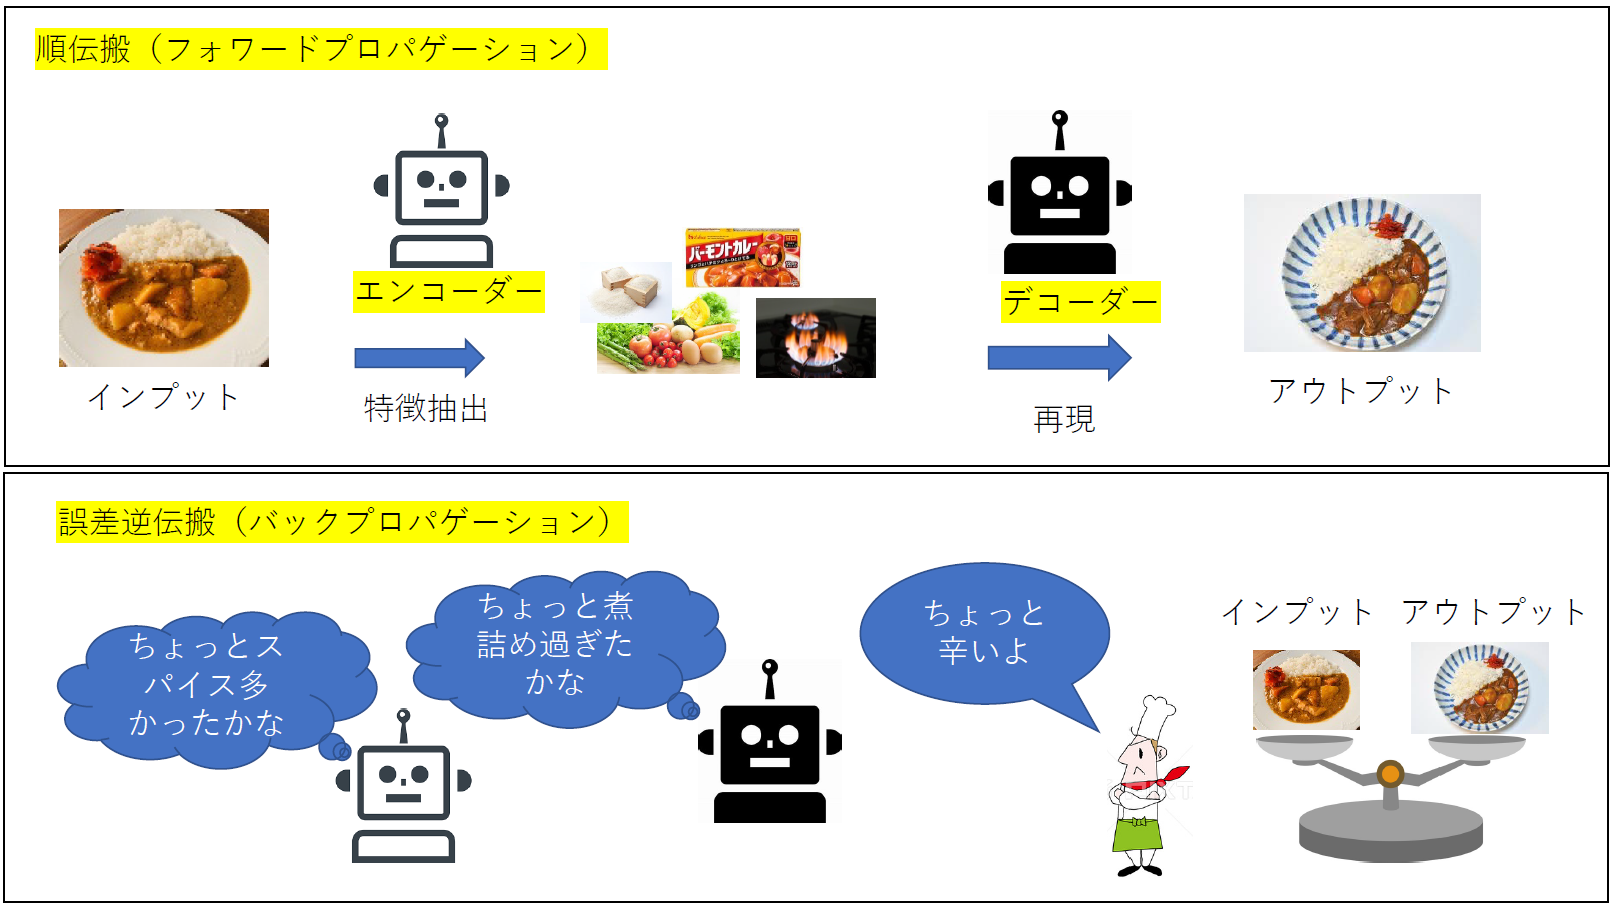

In [ ]:
#18 誤差やパラメータの更新設定

# 誤差の計算
criterion = nn.MSELoss(reduction='mean')
# パラメータの更新
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
#19 GPUの準備
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

AutoEncoder(
  (layers): ModuleList(
    (0): Linear(in_features=320, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): Linear(in_features=128, out_features=8, bias=True)
    (5): Linear(in_features=8, out_features=128, bias=True)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Linear(in_features=128, out_features=128, bias=True)
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): Linear(in_features=128, out_features=320, bias=True)
  )
  (bnorms): ModuleList(
    (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1

#D 学習
学習を開始しモデルを鍛えていきましょう。

#D1. 学習開始

今回は、全ての学習用データをモデルのトレーニングに使用するのではなく、学習データ(3349個)のうち90%(3014個)をモデルのトレーニングに使用し、残りの10%(335個)は学習が適切におこなわれたかの検証用に利用します。

3014個の学習データを使ったトレーニングを１セットとし、今回はこれを50セット繰り返します。

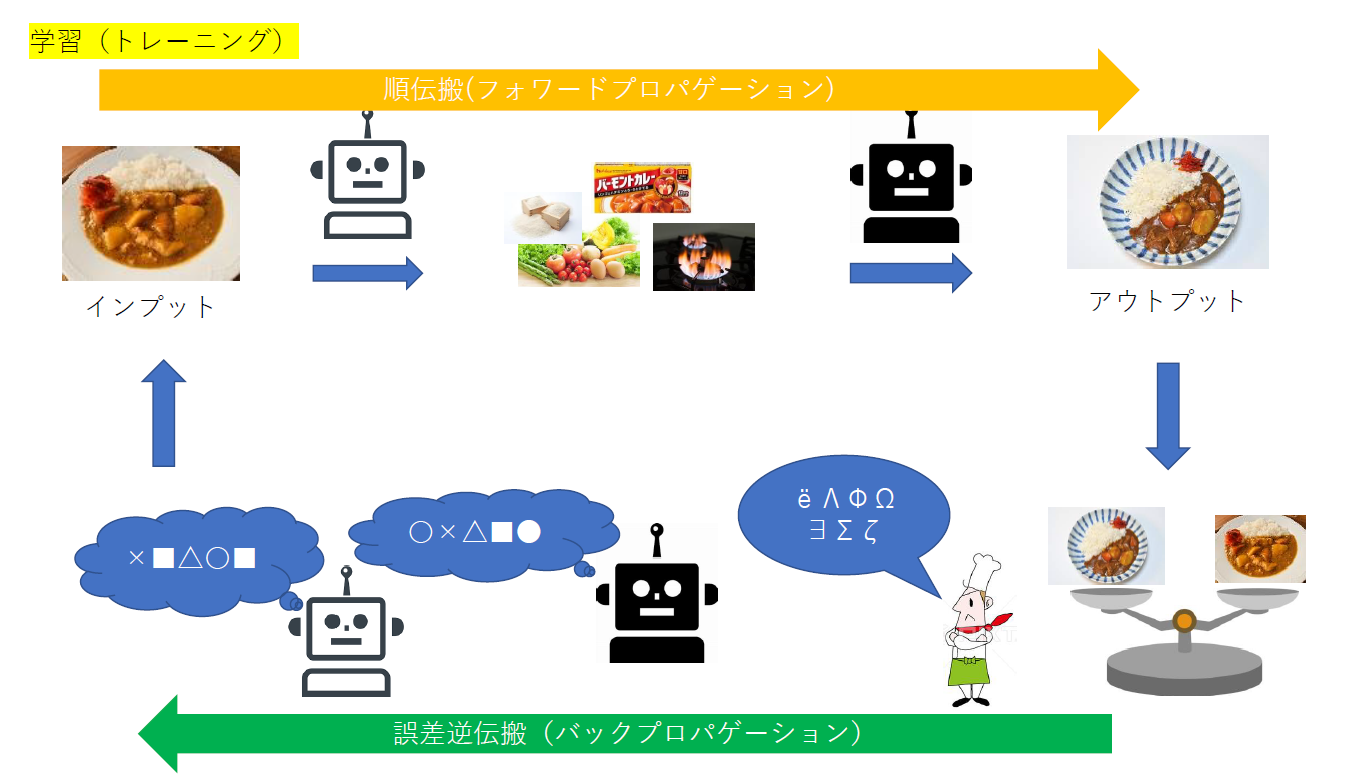

In [ ]:
#20 学習回数を設定する
epochs = 50

In [ ]:
#21 学習の実行
logger.info("============== MODEL TRAINING ==============")
train_loss_on_epoch = []
val_loss_on_epoch = []
for epoch in range(1, epochs + 1):
  model.train()
  train_loss = 0
  train_loss_on_batch = []
  for batch_idx, data in enumerate(train_loader):
    data = data.to(device)  # send data to GPU
    data = data.float()  # workaround
    optimizer.zero_grad()
    reconst = model(data)  # reconstruction through auto encoder
    loss = criterion(data, reconst)  # mean squared error
    loss.backward()  # backpropagation
    train_loss += loss.item()
    optimizer.step()  # update paramerters

    train_loss_on_batch.append(loss.to('cpu').detach().numpy().copy())


  model.eval()  # freeze temporarily
  val_loss = 0
  val_loss_on_batch = []
  with torch.no_grad():
    for batch_idx, data in enumerate(val_loader):
      data = data.to(device)  # send data to GPU
      data = data.float()  # workaround
      reconst = model(data)  # reconstruction through auto encoder
      loss = criterion(data, reconst)  # mean squared error
      val_loss += loss.item()

      val_loss_on_batch.append(loss.to('cpu').detach().numpy().copy())

  # average loss over whole mini-batches
  train_epoch_loss = train_loss / len(train_loader)
  val_epoch_loss = val_loss / len(val_loader)

  train_loss_on_epoch.append(np.mean(train_loss_on_batch))
  val_loss_on_epoch.append(np.mean(val_loss_on_batch))


  logger.info('Epoch: {} Average train_loss: {:.6f},' 
              'Average val_loss: {:.6f}'.format(epoch, train_epoch_loss,
                                                val_epoch_loss))
logger.info("============== END TRAINING ==============")

2021-05-17 12:02:57,283 - INFO - ============== MODEL TRAINING ==============
2021-05-17 12:03:12,701 - INFO - Epoch: 1 Average train_loss: 0.028764,Average val_loss: 0.020855
2021-05-17 12:03:27,919 - INFO - Epoch: 2 Average train_loss: 0.020168,Average val_loss: 0.019307
2021-05-17 12:03:43,297 - INFO - Epoch: 3 Average train_loss: 0.019326,Average val_loss: 0.018775
2021-05-17 12:03:58,522 - INFO - Epoch: 4 Average train_loss: 0.018912,Average val_loss: 0.018508
2021-05-17 12:04:13,857 - INFO - Epoch: 5 Average train_loss: 0.018707,Average val_loss: 0.017986
2021-05-17 12:04:29,153 - INFO - Epoch: 6 Average train_loss: 0.018552,Average val_loss: 0.018438


KeyboardInterrupt: ignored

#D.2 学習の過程を可視化する
トレーニング時の誤差（loss）と検証時の誤差（loss）をグラフにプロットし可視化することで、適切に学習が完了したかが感覚的につかめます。

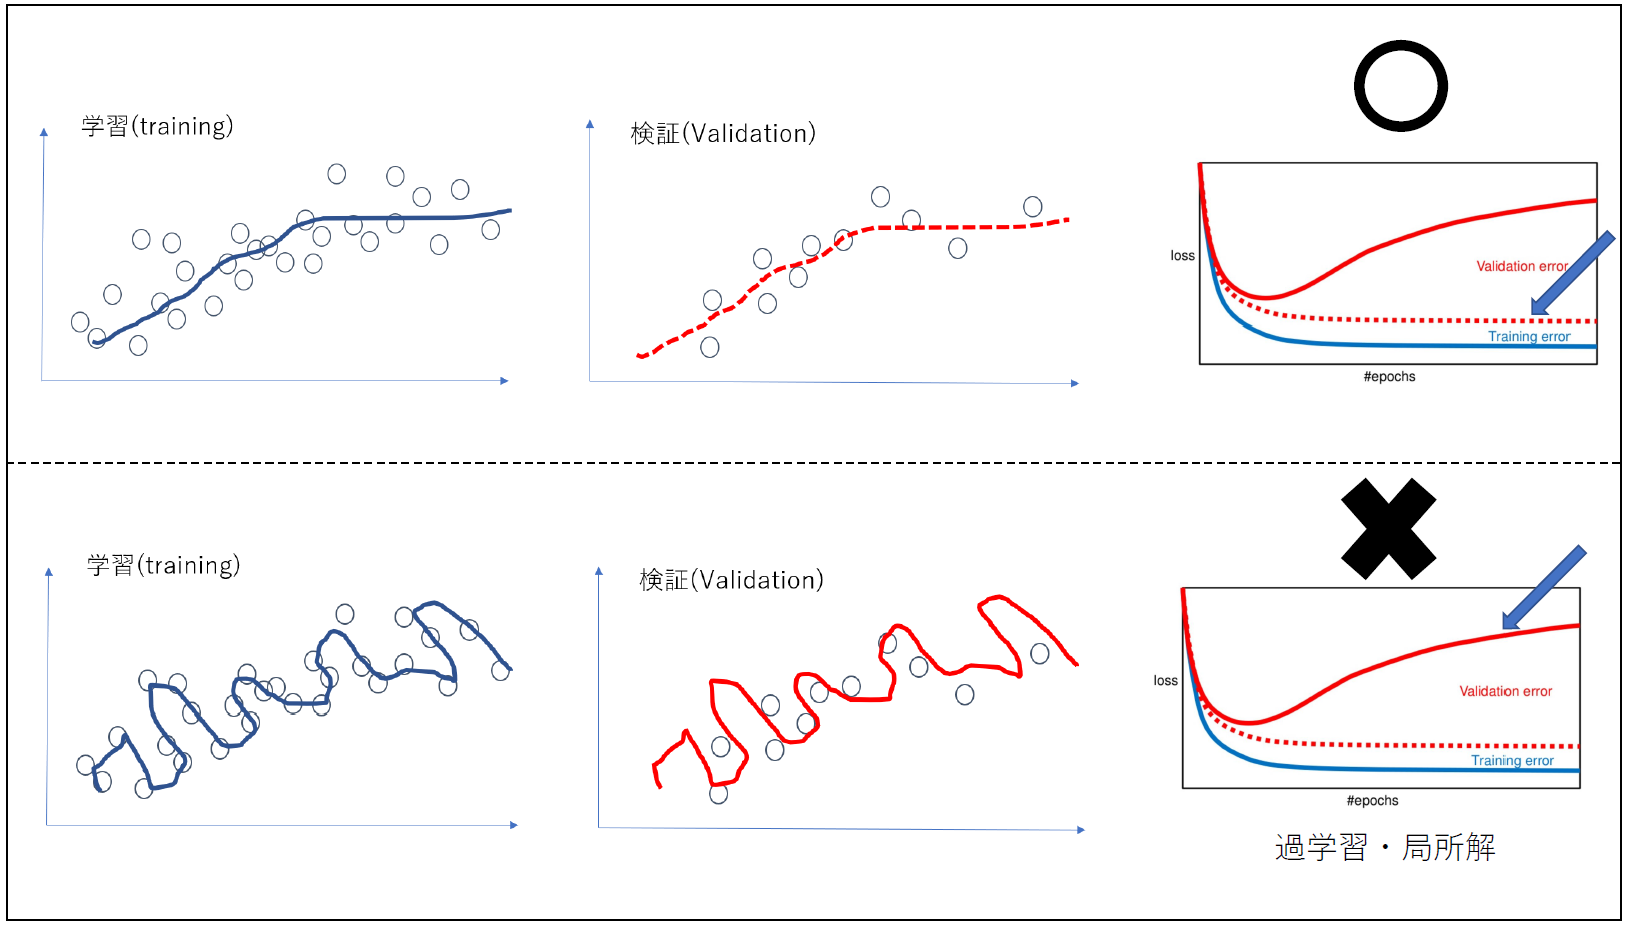

In [ ]:
#22 トレーニング時の誤差（loss）と検証時の誤差（loss）をグラフにプロットする
plt.plot(train_loss_on_epoch, label='train')
plt.plot(val_loss_on_epoch, label="validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

#E モデルの精度を確認する

#E.1 テスト用データセットの作成

学習用のデータセットを作成したのと同じ要領で、モデルの精度を確認するためのテスト用のデータセットを作成します。

In [ ]:
#23 ポンプのモデル(ID)毎の音データのリストを作成する
def get_machine_id_list_for_test(target_dir,
                                 dir_name="test",
                                 ext="wav"):
    # create test files
    dir_path = os.path.abspath("{dir}/{dir_name}/*.{ext}".format(
        dir=target_dir, dir_name=dir_name, ext=ext))
    file_paths = sorted(glob.glob(dir_path))
    # extract id
    machine_id_list = sorted(list(set(itertools.chain.from_iterable(
        [re.findall('id_[0-9][0-9]', ext_id) for ext_id in file_paths]))))
    return machine_id_list

In [ ]:
#24 テスト用のリストを作成する
def test_file_list_generator(target_dir,
                             id_name,
                             dir_name="test",
                             prefix_normal="normal",
                             prefix_anomaly="anomaly",
                             ext="wav"):
    logger.info("target_dir : {}".format(target_dir+"_"+id_name))

    # development
    
    normal_files = sorted(
        glob.glob("{dir}/{dir_name}/{prefix_normal}_{id_name}*.{ext}"
        .format(dir=target_dir,
                dir_name=dir_name,
                prefix_normal=prefix_normal,
                id_name=id_name,
                ext=ext)))
    normal_labels = np.zeros(len(normal_files))
    anomaly_files = sorted(
        glob.glob("{dir}/{dir_name}/{prefix_anomaly}_{id_name}*.{ext}".
                  format(dir=target_dir,
                         dir_name=dir_name,
                         prefix_anomaly=prefix_anomaly,
                         id_name=id_name,
                         ext=ext)))
    anomaly_labels = np.ones(len(anomaly_files))
    files = np.concatenate((normal_files, anomaly_files), axis=0)
    labels = np.concatenate((normal_labels, anomaly_labels), axis=0)
    logger.info("test_file  num : {num}".format(num=len(files)))
    if len(files) == 0:
      logger.exception("no_wav_file!!")
    logger.info("========================================")

    return files, labels


In [ ]:
#25 GPUの準備
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#E.2 テスト用のデータセットを使用して、訓練済みのモデルの精度を確認する

それでは、実際に今回作成したモデルがどれほどの精度でテスト用データを判別できるか実行してみましょう。

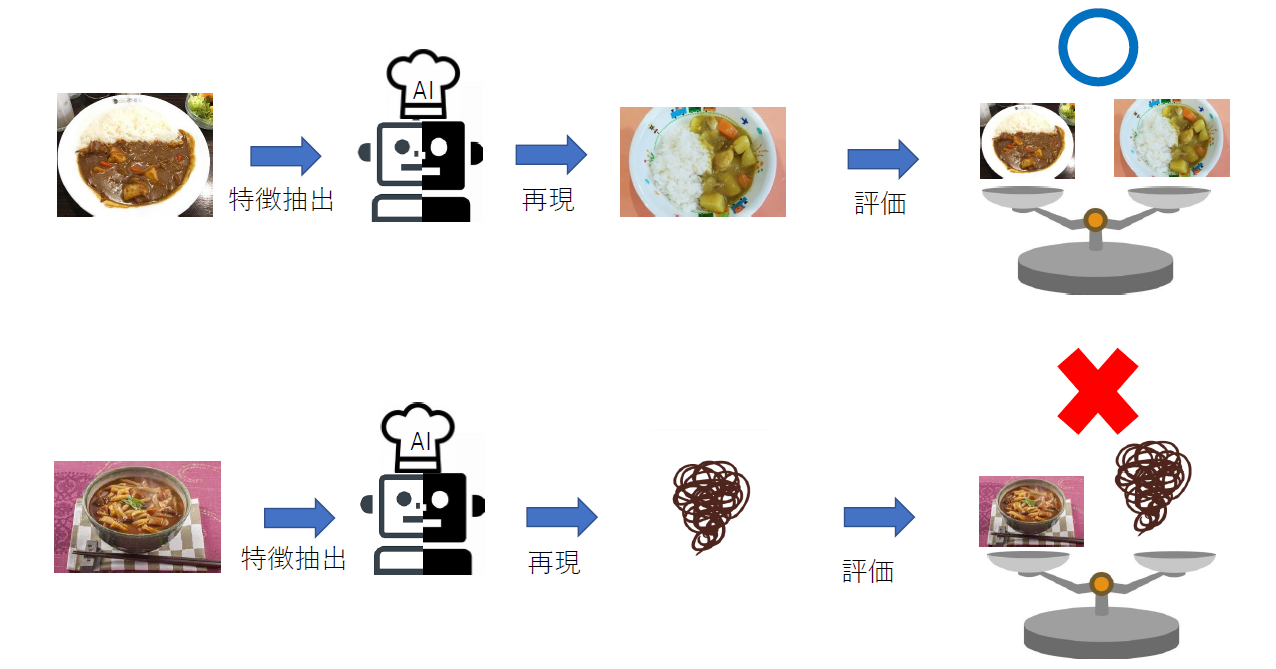

In [ ]:
#26 モデルの精度を確認する
import re
import itertools
import sys
from sklearn import metrics


model.eval()

target_dir = esc_dir
performance = []
machine_id_list = get_machine_id_list_for_test(target_dir)

for id_str in machine_id_list:
  # load list of test files
  test_files, y_true = test_file_list_generator(target_dir, id_str)
  anomaly_score_list = []

  logger.info("============== BEGIN TEST FOR A MACHINE ID ==============")

  y_pred = [0. for k in test_files]

  for file_idx, file_path in enumerate(test_files):
    try:
      data = file_to_vector_array(
          file_path,
          n_mels=64,
          frames=5,
          n_fft=1024,
          hop_length=512,
          power=2.0)

      # reconstruction through auto encoder in pytorch
      feed_data = torch.as_tensor(data, device=device, dtype=torch.float32)
      
      with torch.no_grad():
        pred = model(feed_data).to('cpu').detach().numpy().copy()

      errors = np.mean(np.square(data - pred), axis=1)
      y_pred[file_idx] = np.mean(errors)
      anomaly_score_list.append([os.path.basename(file_path), y_pred[file_idx]])
    except FileNotFoundError:
      logger.error("file broken!!: {}".format(file_path))

  # save anomaly score
  #logger.info("anomaly score result ->  {}".format(anomaly_score_csv))
  auc = metrics.roc_auc_score(y_true, y_pred)
  fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, drop_intermediate=False)
  performance.append([auc])
  logger.info("AUC : {}".format(auc))
  plt.xlabel('FPR: False positive rate')
  plt.ylabel('TPR: True positive rate')
  plt.title('Accuracy of the model:AUC min0 to max 1')
  plt.plot(fpr, tpr, marker='o')
  plt.legend(machine_id_list)
  plt.grid(True)
  logger.info("============ END OF TEST FOR A MACHINE ID ============")
 

# F 評価
今回は、モデルの精度評価にAUC(Area Under the Curve)を採用しています。カーブから下の面積が大きいほど良いモデルで、100発100中で判別できるモデルがあるとするとスコアーは1.0となります。今回体験講座で使用したオートエンコーダーモデルですが、id04のポンプに対しては0.9に近いスコアーでなかなか良い判別精度ですが、id02のポンプに対しては0.5に近いスコアーとなっており、id02のポンプの異常検知には向かない結果となっています。(今回のように正常と異常が半分づつ含まれるテストデータの場合、決め打ちで全てを正常（もしくは異常）と判別した場合には、半分正解できるので0.5というスコアーになります。)